# Продолжение
Основная идея данной части проекта - модификация полученной модели для расширенной классификации 

(добавили класс Other: текст не принадлежит ни одному из описанных в прошлой части проекта классов).


## Новое начало
Подключим необходимые библиотеки, обьявим необходимые функции и константы.

In [202]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
import sys, os
sys.path.append('/Users/nikitos_paravoz/Desktop/DL/NLPClassification/mylib')
import mylib.ecommercedata as edata
import mylib.mymodel
from mylib.ecommercedata import text_preprocess
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [203]:
DEVICE = mylib.mymodel.DEVICE
BATCH_SIZE = 32

In [204]:
category_dict = {'Household': 0, 'Books': 1, 'Clothing & Accessories': 2, 'Electronics' : 3}
category = ['Household', 'Books', 'Clothing & Accessories', 'Electronics']
data, max_len = edata.prepare_data('ecommerceDataset.csv', category_dict)

In [205]:
def show_data_balance(data, category_dict, text_title):
    val = []
    lab = []
    for k, v in category_dict.items():
        val.append(len(data[data['category'] == v]))
        lab.append(k)
    fig = go.Figure(data = [go.Pie(values = val, labels = lab, hole = 0.5, textinfo = 'percent', title = " ")])
    fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95)) 
    fig.show()

In [206]:
show_data_balance(data, category_dict, "Unbalanced data")

### Баланс классов
Если в нулевом задании баланс классов нас не заботил, мы подходили к разработке модели теоретически, то теперь, при добавлении нового класса нам бы хотелось иметь более сбалансированный датасет, так как это серьезно скажется на реальной работе нашей модели, которую мы будем использовать в дальнейшем.


Каким образом мы будем создавать сбалансированный датасет? Как видно, класс Household имеет серьезное количественное преимущество, относительно 3 других, если обрезать его - будет баланс, но при этом мы сильно уменьшим датасет, готовы ли мы терять 20% датасета ради баланса? 

Воспользуемся аугментацией данных! Усредним все классы таким образом: Household урежем, но не сильно, 3 другие мы наоборот увеличим, получив тем самым сбалансированный датасет примерно такого же размера, что и раньше.

In [207]:
import random, gensim
modelfsttxt = gensim.models.KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

In [208]:
embedding_dict = modelfsttxt.key_to_index

Напишем функцию аугментации; слова в тексте будут заменятся на синонимы

In [209]:
def get_synonyms(word, emb_dict=embedding_dict, model=modelfsttxt, temp=5):
	synonyms = set()
	if word not in emb_dict:
		return list(synonyms)
	for syn, _ in model.most_similar(word, topn=temp):
		synonyms.add(text_preprocess(syn))
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

In [210]:
def augmentate_word(words, n):
    words = words.split()
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    return ' '.join(new_words)

Теперь напишем функции oversample, для дополнения малых классов до средних, и undersample, для урезания данных до средних.

In [211]:
def oversample_data(data, target, howmuch, temp=10):
    new_text = []
    data_trg = data[data['category'] == target]
    for i in np.random.randint(0,len(data_trg), howmuch):
        text = data_trg.iloc[i]['description']
        augmented_text = augmentate_word(text, int(len(text.split())/temp))
        new_text.append(augmented_text)
    new = pd.DataFrame({'description':new_text,'category':target})
    data = pd.concat([data, new], axis=0)
    return data

In [212]:
def undersample_data(data, target, howmuch):
    drop_indices = np.random.choice(data[data['category'] == target].index, howmuch, replace=False)
    data = data.drop(drop_indices)
    return data

Наконец, объединим наши функции в одну, для общей балансировки классов.

In [213]:
def balance_data(data, strategy : dict[int, float]):
    for k, v in strategy.items():
        if v < 0:
            data = undersample_data(data, k, int(-v*len(data[data['category'] == k])))
        else:
            data = oversample_data(data, k, int(v*len(data[data['category'] == k])))
    return data

In [214]:
#strat = {0: -0.3, 1: 0.18, 2: 0.18, 3: 0.34}
#balanced_data = balance_data(data, strat) мы сохранили вывод данной операции в отдельный файл .csv, чтобы каждый раз не ждать балансировки.
balanced_data, max_len = edata.prepare_data('balanced_ecommerceDataset.csv', category_dict)

In [215]:
show_data_balance(balanced_data, category_dict, "Data after balancing")

## Создание нового класса
Добавим новый класс 'Other', для баланса, его размер подобен размерам вышеописанных классов.
На просторах интернета были найдены 2 датасета: OtherDataset.csv (это reviews с Amazon) и multinli*.jsonl (это предложения с достаточно обширным языковым словарем)

In [216]:
candidate1, new_len = edata.prepare_data('OtherDataset.csv', {'Other' : 1})
candidate2 = pd.read_json('multinli_1.0_train.jsonl', lines=True)

Теперь из наших кандидатов для класса Other надо выделить те текста, на которых модели из прошлого пункта плохо удается распознать класс.

Загрузим модель из прошлого пункта:

In [217]:
model = mylib.mymodel.LSTM_Classifier(48806, 300, 100, 4, 1, True)
model.load_state_dict(torch.load('saved_model.pt'))
model.eval()
model.to(DEVICE)
X = balanced_data['description']
y = balanced_data['category']
vocabulary, vocabulary_to_int = edata.build_vocab(X)

Напишем функцию, отсеивающая из датасетов текста, обладающие свойством описанным выше:

In [218]:
def badpredict(text, howbad=0.7, model=model):
    text = text_preprocess(text)
    text_tok = edata.small_tokenize(text, vocabulary_to_int, max_len)
    with torch.no_grad():
        x, h = text_tok.reshape(1, len(text_tok)).to(DEVICE),  model.init_hidden(1)
        out, _, attn_weights = model(x, h)
        prediction = float(torch.max(torch.exp(out)))
        return (prediction < howbad)

In [219]:
rows_list = []
maxtexts = 10000
for text in pd.concat([candidate1['description'], candidate2['sentence1']], axis=0):
    if len(text.split()) < random.randint(1, 30):
        continue
    if badpredict(text):
        dictrow = {'category' : 'Other' ,'description' : text}
        rows_list.append(dictrow)
        maxtexts -= 1
        if maxtexts < 0:
            break
otherdata = pd.DataFrame(rows_list)

In [221]:
otherdata.to_csv('optimal_other_dataset.csv', index=False)

Теперь в optimal_other_dataset.csv лежит датасет из текстов, которые реально можно представить как other ;)

In [234]:
optim_other_data, other_len = edata.prepare_data('optimal_other_dataset.csv', {'Other' : 4})

In [235]:
newdata = pd.concat([balanced_data, optim_other_data], axis=0).reset_index(drop=True)
X = newdata['description']
y = newdata['category']
vocabulary, vocabulary_to_int = edata.build_vocab(X)
X_tok = edata.huge_tokenize(X, vocabulary_to_int).to(int)

In [261]:
#strat = {0: 0, 1: 0.1, 2: 0.05, 3: 0.15, 4: 0}
#balanced_newdata = balance_data(newdata, strat) сбалансированный класс теперь лежит в balanced_5class.csv
new_category = ['Household', 'Books', 'Clothing & Accessories', 'Electronics', 'Other']
new_category_dict = {'Household': 0, 'Books': 1, 'Clothing & Accessories': 2, 'Electronics' : 3, 'Other' : 4}
balanced_newdata, max_len = edata.prepare_data('balanced_5class.csv', new_category_dict)

In [262]:
show_data_balance(balanced_newdata, new_category_dict, "balanced 5class data")

## Новый датасет, новая жизнь

Создадим новый датасет обучим модель на 5 классов, протестируем, подведем итоги.

In [263]:
train_indices, test_indices = edata.train_test_indices(newdata)
X_train = [X_tok[idx] for idx in train_indices]
y_train = [y[idx] for idx in train_indices]
X_test = [X_tok[idx] for idx in test_indices]
y_test = [y[idx] for idx in test_indices]
train_dataset = edata.EcommerceDataset(X_train, y_train)
test_dataset = edata.EcommerceDataset(X_test, y_test)
trainval_size = len(train_dataset)
val_size = int(trainval_size * 0.15)
train_size = trainval_size - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [264]:
VOCAB_SIZE = len(vocabulary) + 1
EMBEDDING_DIM = 300
HIDDEN_DIM = 100
NUM_CLASSES = 5
LSTM_LAYERS = 1
IS_BIDIRECTIONAL = True
LR = 1e-4
def prepare_matrix(embedding_dict):
    embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    for word, token in vocabulary:
        if word in embedding_dict:
            embedding_vector = embedding_dict[word]
            embedding_matrix[token] = embedding_vector

    return embedding_matrix

In [265]:
model = mylib.mymodel.LSTM_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, IS_BIDIRECTIONAL)
model = model.to(DEVICE)
embedding_matrix = prepare_matrix(embedding_dict)
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
model.embedding.weight.requirges_grad = True

In [266]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [267]:
model = mylib.mymodel.train(model, train_loader, valid_loader, DEVICE, criterion, optimizer, 15)

Epoch 1/15 finished: train_accuracy = 76.17%, train_loss = 0.8273873600959778
Validation accuracy increased (0.00 --> 76.17).  Saving model ...
Epoch 2/15 finished: train_accuracy = 87.0%, train_loss = 0.404341006398201
Validation accuracy increased (76.17 --> 87.00).  Saving model ...
Epoch 3/15 finished: train_accuracy = 89.75%, train_loss = 0.341627614736557
Validation accuracy increased (87.00 --> 89.75).  Saving model ...
Epoch 4/15 finished: train_accuracy = 90.62%, train_loss = 0.3335859438478947
Validation accuracy increased (89.75 --> 90.62).  Saving model ...
Epoch 5/15 finished: train_accuracy = 90.83%, train_loss = 0.3353956820219755
Validation accuracy increased (90.62 --> 90.83).  Saving model ...
Epoch 6/15 finished: train_accuracy = 91.05%, train_loss = 0.34233456125855444
Validation accuracy increased (90.83 --> 91.05).  Saving model ...
Epoch 7/15 finished: train_accuracy = 90.65%, train_loss = 0.3928824056982994
Validation accuracy did not increase
Epoch 8/15 finishe

In [282]:
model.load_state_dict(torch.load('new_model.pt'))
model.eval()

LSTM_Classifier(
  (embedding): Embedding(51330, 300, padding_idx=0)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [283]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
def make_some_metrics(test_accuracy, test_loss, y_true, y_pred, category_list, modelname):
    print(f'Testing finished for {modelname}: Accuracy =  {test_accuracy}%, Loss = {test_loss} \nClassification report:\n', classification_report(y_true, y_pred, target_names=category_list))
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=category_list)
    cm_display.plot(cmap="BuPu", xticks_rotation=45)

Testing finished for new 5class model: Accuracy =  96.61%, Loss = 0.1706053398106176 
Classification report:
                         precision    recall  f1-score   support

             Household       0.97      0.96      0.96      1322
                 Books       0.92      0.96      0.94      1265
Clothing & Accessories       0.99      0.98      0.98      1255
           Electronics       0.97      0.96      0.97      1157
                 Other       0.98      0.97      0.97      1689

              accuracy                           0.97      6688
             macro avg       0.97      0.97      0.97      6688
          weighted avg       0.97      0.97      0.97      6688



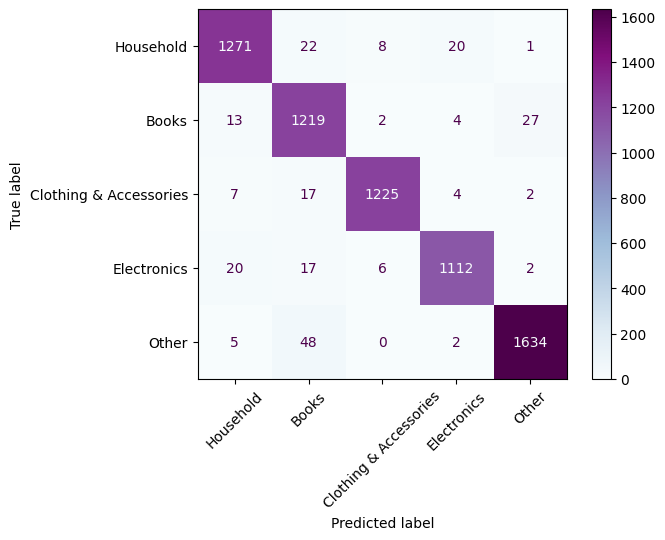

In [284]:
test_accuracy, test_loss, y_pred_list, y_test_list = mylib.mymodel.test(model, DEVICE, test_loader, criterion)
make_some_metrics(test_accuracy, test_loss, y_test_list, y_pred_list, new_category, "new 5class model")

## Заключение
Теперь у нас есть модель, классифицирующая наши данные на 5 классов.

In [285]:
def predict_single(text, model=model, temp=5, inverse_category_list=new_category):
    text = text_preprocess(text)
    text_tok = edata.small_tokenize(text, vocabulary_to_int, max_len)
    splitted = text.split()
    actual_length = len(splitted)
    with torch.no_grad():
        x, h = text_tok.reshape(1, len(text_tok)).to(DEVICE),  model.init_hidden(1)
        out, _, attn_weights = model(x, h)
        attn_weights = attn_weights.cpu()
        temp = actual_length - 1 if temp > actual_length else temp
        _, important_tokens_base = torch.topk(attn_weights.squeeze(0)[:actual_length].unsqueeze(0), temp, dim=1)
        important_text = [splitted[token.to(int)] for token in important_tokens_base.squeeze(0) if token.to(int) in range(0, actual_length)]
        prediction = torch.argmax(out, dim=1).to(int)
        if prediction == 4:
            return inverse_category_list[prediction]
        colors = sns.color_palette("plasma", n_colors=actual_length)
        plt.figure(figsize=(actual_length, actual_length/temp))
        bars = plt.bar(range(actual_length), attn_weights.squeeze(0)[:actual_length], color=colors)
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), splitted[i], ha='center', va='bottom', rotation=0, fontsize=8, color='black')
        plt.xlabel("Words")
        plt.ylabel("Attention")
        plt.show()
        return inverse_category_list[prediction], important_text

In [286]:
predict_single("This is example for other class i think, anything else would be embarrasing")

'Other'